In [1]:
# Import important libraries
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import gdown
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Embedding
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Constants
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Downloading And Loading the dataset

In [3]:
# Google Drive file_ids of commercial and non-commercial audio-video features
commercialFeatures_150_file_id          = "1ucT-jrkmhRHx8RSMW0bueGD2IjL3ZpiO"
nonCommercialFeatures_150_file_id       = "1uA5sdu_5b2l0z8k_aI0NeG2eqWsdX9zi"

# Destination paths
commercialFeatures_150_destination      = "commercialFeatures_150.pkl"
nonCommercialFeatures_150_destination   = "nonCommercialFeatures_150.pkl"

In [4]:
def download_file_from_google_drive(file_id, destination):
    """
    Download a file from Google Drive if it doesn't already exist locally.

    Parameters:
    - file_id (str): The unique file ID from Google Drive.
    - destination (str): The local path where the file should be saved.
    """
    if os.path.exists(destination):
        print(f'File already exists at {destination}. Skipping download.')
    else:
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, destination, quiet=False)

In [5]:
# Downloading commercialFeatures
download_file_from_google_drive(commercialFeatures_150_file_id, commercialFeatures_150_destination)

# Downloading nonCommercialFeatures
download_file_from_google_drive(nonCommercialFeatures_150_file_id, nonCommercialFeatures_150_destination)

Downloading...
From (original): https://drive.google.com/uc?id=1ucT-jrkmhRHx8RSMW0bueGD2IjL3ZpiO
From (redirected): https://drive.google.com/uc?id=1ucT-jrkmhRHx8RSMW0bueGD2IjL3ZpiO&confirm=t&uuid=55a904a1-840c-45e5-9edf-f5852dd1a57e
To: /content/commercialFeatures_150.pkl
100%|██████████| 6.03G/6.03G [00:32<00:00, 188MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1uA5sdu_5b2l0z8k_aI0NeG2eqWsdX9zi
From (redirected): https://drive.google.com/uc?id=1uA5sdu_5b2l0z8k_aI0NeG2eqWsdX9zi&confirm=t&uuid=6efb867b-ac85-4044-96f2-a7e8ec3285a8
To: /content/nonCommercialFeatures_150.pkl
100%|██████████| 6.35G/6.35G [01:20<00:00, 78.7MB/s]


In [6]:
def load_features():
    """
    Load data from a pickled file if it exists, otherwise initialize an empty list.

    Returns:
    - commercialFeatures_150 (list) - List containing Commercial video features
    - nonCommercialFeatures_150 (list) - List containing nonCommercial video features
    """
    with open('commercialFeatures_150.pkl', 'rb') as f:
        commercialFeatures_150 = pickle.load(f)
    with open('nonCommercialFeatures_150.pkl', 'rb') as f:
        nonCommercialFeatures_150 = pickle.load(f)

    print(f'Number of commercial features: {len(commercialFeatures_150)}')
    print(f'Number of nonCommercial features: {len(nonCommercialFeatures_150)}')
    print("Audio-Visual Features Loaded Successfully")
    return commercialFeatures_150, nonCommercialFeatures_150

In [7]:
commercialFeatures_150, nonCommercialFeatures_150 = load_features()

Number of commercial features: 4364
Number of nonCommercial features: 4597
Audio-Visual Features Loaded Successfully


In [8]:
print(commercialFeatures_150.shape)

(4364, 150, 1152)


In [9]:
print(nonCommercialFeatures_150.shape)

(4597, 150, 1152)


# Generating labels for data and merging commercial and non-commercial features and shuffling data randomly

In [10]:
# Generating labels
commercial_labels = np.ones(len(commercialFeatures_150))
non_commercial_labels = np.zeros(len(nonCommercialFeatures_150))

In [ ]:
# Merging commercial and non-commercial features
X = np.concatenate((commercialFeatures_150, nonCommercialFeatures_150), axis=0)
Y = np.concatenate((commercial_labels, non_commercial_labels), axis=0)

In [ ]:
# delting few variables storing huge data which is not required for coming cells to avoid kernel crash error
del commercialFeatures_150
del nonCommercialFeatures_150
del commercial_labels
del non_commercial_labels

In [ ]:
print(f'Shape of data is {X.shape}')
print(f'Shape of labels is {Y.shape}')

Shape of data is (8961, 150, 1152)
Shape of labels is (8961,)


In [ ]:
# Shuffling data randomly
X, Y = shuffle(X, Y, random_state=42)

# Preprocess the data

In [ ]:
print(X[0][0])

[219.  78. 255. ... 124. 141. 177.]


In [ ]:
# Finding Range of data
maxi = 0
mini = 1000
for i in range(len(X[0][0])):
    maxi = max(maxi, X[0][0][i])
    mini = min(mini, X[0][0][i])

In [ ]:
print(f'maximum value is {maxi}')
print(f'minimum value is {mini}')

maximum value is 255.0
minimum value is 0.0


In [ ]:
def scale_data(data):
    """
    Scale the input data by dividing by 255.

    Parameters:
    data (numpy.ndarray): Input data array of shape [samples, features] or higher dimensions.

    Returns:
    numpy.ndarray: Scaled data with values in the range [0, 1].
    """

    scaled_data = data / 255.0
    return scaled_data

In [ ]:
X = scale_data(X)

In [ ]:
print(X[0][0])

[0.85882353 0.30588235 1.         ... 0.48627451 0.55294118 0.69411765]


In [ ]:
def standardize_data(data):
    """
    Standardize the input data.

    Parameters:
    data (numpy.ndarray): Input data array of shape [samples, features] or higher dimensions.
                          If the input has more than 2 dimensions, the function will flatten the
                          data along the features axis, standardize, and then reshape back.

    Returns:
    numpy.ndarray: Standardized data with mean 0 and standard deviation 1 along the features axis.
    """

    original_shape = data.shape
    if len(original_shape) > 2:
        data = data.reshape(-1, original_shape[-1])

    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data)

    if len(original_shape) > 2:
        standardized_data = standardized_data.reshape(original_shape)

    return standardized_data

In [ ]:
X = standardize_data(X)

In [ ]:
print(X[0][0])

[ 1.55840786 -0.51457659  3.16766892 ...  0.02947117  0.20901008
  0.56678746]


# Train, Test and Validation split

In [ ]:
def split_data(data, labels, train_ratio=0.7, valid_ratio=0.15, test_ratio=0.15, random_state=None):
    """
    Split data into training, validation, and test sets.

    Parameters:
    data (numpy.ndarray): The input data of shape [samples, features].
    labels (numpy.ndarray): The corresponding labels of shape [samples,].
    train_ratio (float): The ratio of the training set. Default is 0.7.
    valid_ratio (float): The ratio of the validation set. Default is 0.15.
    test_ratio (float): The ratio of the test set. Default is 0.15.
    random_state (int, optional): Random seed for reproducibility.

    Returns:
    tuple: Tuple containing:
        - train_data (numpy.ndarray): Training data.
        - valid_data (numpy.ndarray): Validation data.
        - test_data (numpy.ndarray): Test data.
        - train_labels (numpy.ndarray): Training labels.
        - valid_labels (numpy.ndarray): Validation labels.
        - test_labels (numpy.ndarray): Test labels.
    """

    assert train_ratio + valid_ratio + test_ratio == 1, "Ratios must sum to 1."

    train_data, temp_data, train_labels, temp_labels = train_test_split(
        data, labels, test_size=(1 - train_ratio), random_state=random_state
    )

    temp_ratio = valid_ratio + test_ratio
    valid_ratio_relative = valid_ratio / temp_ratio
    test_ratio_relative = test_ratio / temp_ratio

    valid_data, test_data, valid_labels, test_labels = train_test_split(
        temp_data, temp_labels, test_size=test_ratio_relative, random_state=random_state
    )

    return train_data, valid_data, test_data, train_labels, valid_labels, test_labels

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, Y, random_state=42)


In [ ]:
print(f'Train data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')
print(f'Test data shape: {X_test.shape}')

Train data shape: (6272, 150, 1152)
Validation data shape: (1344, 150, 1152)
Test data shape: (1345, 150, 1152)


In [ ]:
print(f'Train labels shape: {y_train.shape}')
print(f'Validation labels shape: {y_val.shape}')
print(f'Test labels shape: {y_test.shape}')

Train labels shape: (6272,)
Validation labels shape: (1344,)
Test labels shape: (1345,)


# Unidirectional LSTM **Model**

In [ ]:
def unidirectional_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
input_shape = (len(X_train[0]), len(X_train[0][0]))
uni_LSTM_Model = unidirectional_lstm_model(input_shape)
uni_LSTM_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150, 256)          1442816   
                                                                 
 dropout (Dropout)           (None, 150, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 150, 128)          197120    
                                                                 
 dropout_1 (Dropout)         (None, 150, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2



## Model Training



In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = uni_LSTM_Model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
196/196 [==============================] - 14s 41ms/step - loss: 0.2583 - accuracy: 0.9098 - val_loss: 0.1527 - val_accuracy: 0.9435
Epoch 2/10
196/196 [==============================] - 5s 26ms/step - loss: 0.1160 - accuracy: 0.9624 - val_loss: 0.1278 - val_accuracy: 0.9539
Epoch 3/10
196/196 [==============================] - 5s 26ms/step - loss: 0.0724 - accuracy: 0.9783 - val_loss: 0.0973 - val_accuracy: 0.9695
Epoch 4/10
196/196 [==============================] - 5s 26ms/step - loss: 0.0399 - accuracy: 0.9879 - val_loss: 0.1401 - val_accuracy: 0.9591
Epoch 5/10
196/196 [==============================] - 5s 26ms/step - loss: 0.0368 - accuracy: 0.9892 - val_loss: 0.1526 - val_accuracy: 0.9606
Epoch 6/10
196/196 [==============================] - 5s 26ms/step - loss: 0.0499 - accuracy: 0.9825 - val_loss: 0.1298 - val_accuracy: 0.9680
Epoch 7/10
196/196 [==============================] - 5s 26ms/step - loss: 0.0216 - accuracy: 0.9946 - val_loss: 0.1629 - val_accuracy: 0.959

## Evaluating model on Test data

In [ ]:
test_loss, test_accuracy = uni_LSTM_Model.evaluate(X_test, y_test)

43/43 [==============================] - 2s 14ms/step - loss: 0.1135 - accuracy: 0.9628


In [ ]:
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Test Loss: 0.1135210320353508
Test Accuracy: 0.9628252983093262


In [ ]:
y_pred = (uni_LSTM_Model.predict(X_test) > 0.5).astype("int32")

43/43 [==============================] - 2s 13ms/step


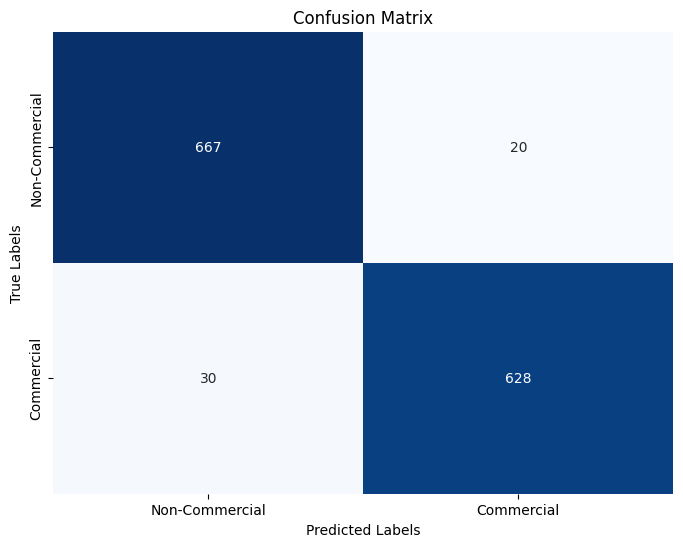

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Non-Commercial', 'Commercial'],
            yticklabels=['Non-Commercial', 'Commercial'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       687
         1.0       0.97      0.95      0.96       658

    accuracy                           0.96      1345
   macro avg       0.96      0.96      0.96      1345
weighted avg       0.96      0.96      0.96      1345



## Exporting the trained uni_LSTM model

In [ ]:
uni_LSTM_Model.save('./uni_LSTM_Model.keras')

# Bidirectional LSTMs

In [ ]:
def create_bidirectional_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
input_shape = (150, 1152)
bidirectional_lstm_model = create_bidirectional_lstm_model(input_shape)
bidirectional_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 150, 512)          2885632   
 al)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 150, 512)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 150, 256)          656384    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 150, 256)          0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                      

## Model Training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = bidirectional_lstm_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
    # callbacks=[early_stopping]
)

Epoch 1/10
196/196 [==============================] - 10s 51ms/step - loss: 0.0698 - accuracy: 0.9774 - val_loss: 0.0930 - val_accuracy: 0.9688
Epoch 2/10
196/196 [==============================] - 8s 42ms/step - loss: 0.0345 - accuracy: 0.9880 - val_loss: 0.1134 - val_accuracy: 0.9710
Epoch 3/10
196/196 [==============================] - 8s 42ms/step - loss: 0.0169 - accuracy: 0.9943 - val_loss: 0.1217 - val_accuracy: 0.9702
Epoch 4/10
196/196 [==============================] - 8s 42ms/step - loss: 0.0080 - accuracy: 0.9978 - val_loss: 0.1320 - val_accuracy: 0.9702
Epoch 5/10
196/196 [==============================] - 9s 44ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.1658 - val_accuracy: 0.9695
Epoch 6/10
196/196 [==============================] - 8s 42ms/step - loss: 0.0084 - accuracy: 0.9978 - val_loss: 0.1403 - val_accuracy: 0.9717
Epoch 7/10
196/196 [==============================] - 8s 42ms/step - loss: 0.0087 - accuracy: 0.9971 - val_loss: 0.1985 - val_accuracy: 0.954

## Model Evaluation

In [ ]:
test_loss, test_accuracy = bidirectional_lstm_model.evaluate(X_test, y_test)

43/43 [==============================] - 3s 20ms/step - loss: 0.1729 - accuracy: 0.9643


In [ ]:
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Test Loss: 0.17286346852779388
Test Accuracy: 0.9643122553825378


In [ ]:
y_pred = (bidirectional_lstm_model.predict(X_test) > 0.5).astype("int32")

43/43 [==============================] - 3s 19ms/step


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

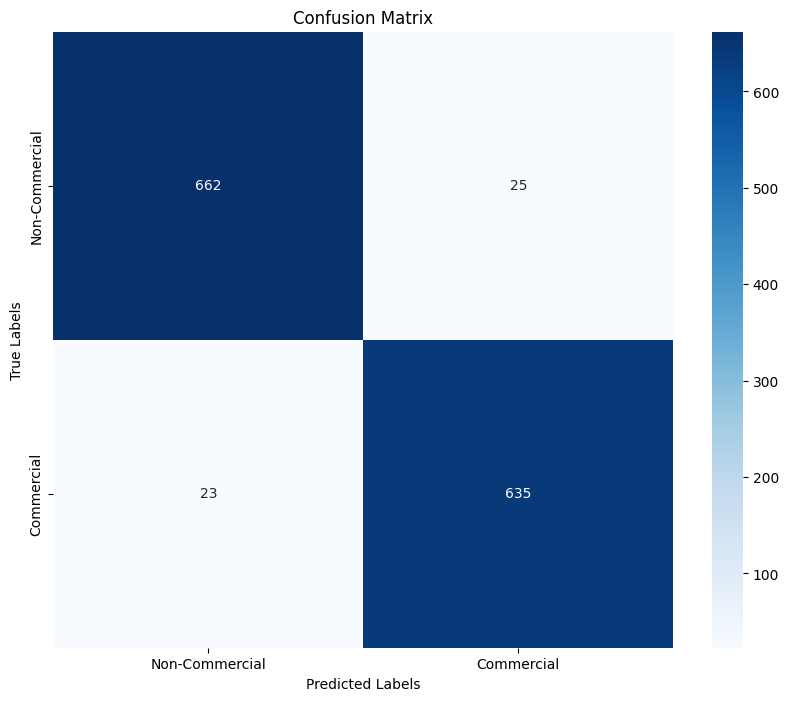

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Commercial', 'Commercial'], yticklabels=['Non-Commercial', 'Commercial'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Exporting the trained model

In [ ]:
bidirectional_lstm_model.save('./bidirectional_lstm_model.keras')

# CNNs Model

In [ ]:
def cnn_model(input_shape):
    model = Sequential()

    model.add(Reshape((input_shape[0], input_shape[1], 1), input_shape=input_shape))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
input_shape = (150, 1152)
cnn_model = cnn_model(input_shape)
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 150, 1152, 1)      0         
                                                                 
 conv2d (Conv2D)             (None, 150, 1152, 32)     320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 576, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 576, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 288, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 288, 128)     

## Model training

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = cnn_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
    # callbacks=[early_stopping]
)

Epoch 1/20
196/196 [==============================] - 9s 43ms/step - loss: 0.1138 - accuracy: 0.9585 - val_loss: 0.2042 - val_accuracy: 0.9323
Epoch 2/20
196/196 [==============================] - 7s 34ms/step - loss: 0.1007 - accuracy: 0.9636 - val_loss: 0.1949 - val_accuracy: 0.9196
Epoch 3/20
196/196 [==============================] - 7s 34ms/step - loss: 0.0923 - accuracy: 0.9644 - val_loss: 0.2042 - val_accuracy: 0.9293
Epoch 4/20
196/196 [==============================] - 7s 34ms/step - loss: 0.0535 - accuracy: 0.9831 - val_loss: 0.2528 - val_accuracy: 0.9182
Epoch 5/20
196/196 [==============================] - 7s 34ms/step - loss: 0.0435 - accuracy: 0.9841 - val_loss: 0.2665 - val_accuracy: 0.9353
Epoch 6/20
196/196 [==============================] - 7s 34ms/step - loss: 0.0341 - accuracy: 0.9877 - val_loss: 0.3604 - val_accuracy: 0.9278
Epoch 7/20
196/196 [==============================] - 7s 34ms/step - loss: 0.0246 - accuracy: 0.9915 - val_loss: 0.4072 - val_accuracy: 0.9234

## Model Evaluation

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)

43/43 [==============================] - 1s 16ms/step - loss: 0.4215 - accuracy: 0.9197


In [ ]:
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Test Loss: 0.4215257167816162
Test Accuracy: 0.9197025895118713


In [ ]:
y_pred = (cnn_model.predict(X_test) > 0.5).astype("int32")

43/43 [==============================] - 1s 12ms/step


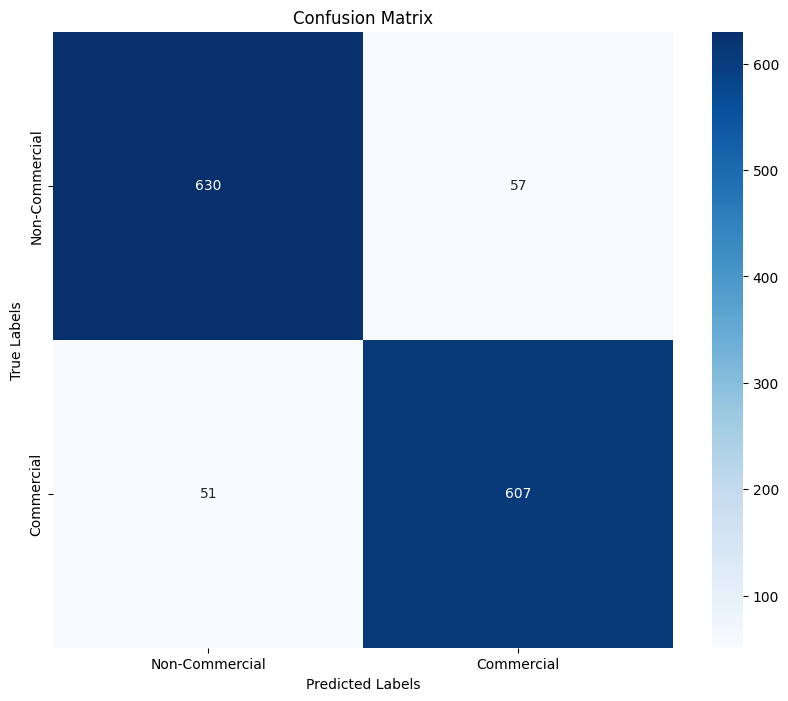

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Commercial', 'Commercial'], yticklabels=['Non-Commercial', 'Commercial'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Exporting the trained model

In [ ]:
cnn_model.save('./cnn_model.keras')